In [106]:
from IPython.display import FileLink, Image
import pandas as pd
import pandas.rpy.common as com
import brewer2mpl
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import gridspec
from matplotlib import collections
import numpy as np
from numpy import nan, min, array
import itertools
from mpltools import style
style.use("ggplot")
%matplotlib inline
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
%%R
library(phyloseq)
library(plyr); library(dplyr)

/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


  warnings.warn(x, RRuntimeWarning)
/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)


In [4]:
%%R
physeq = import_biom("../../SeqData/otu_table.tax.meta.biom",
                     "../../SeqData/fulltree.tre", 
                     parseFunction = parse_taxonomy_greengenes)

In [295]:
%%R
df = read.csv("../../SeqData/l2fc.csv")
df$Minerals = "Minerals"
write.table(df, file = "../data/l2fcResp.csv",sep=",")

In [296]:
matplotlib.rcParams["axes.facecolor"] = "white"
matplotlib.rcParams["axes.edgecolor"] = "#151515"
matplotlib.rcParams["grid.color"] = "#959595"
matplotlib.rcParams["grid.alpha"] = "0.50"
matplotlib.rcParams["font.size"] = 7.5

In [316]:
def get_l2fc_df(df_fp, taxon, rank):
    df = pd.read_csv(df_fp, sep=",")
    df_subset = df[df[rank]==taxon]
    return df_subset, df_subset["OTU"]

def get_tree_df(physeq_str, OTUs):
    subset_fn_str = "prune_taxa(OTUs, %s)" %physeq_str
    %Rpush subset_fn_str
    %Rpush OTUs
    %R -n OTUs = as.character(OTUs)
    %R -n ps = eval(parse(text=subset_fn_str))
    %R -n tree_dfs = phyloseq:::tree_layout(phy_tree(ps), ladderize="right")
    %R -n tax = data.frame(tax_table(ps), stringsAsFactors = FALSE)
    %R -n tax$OTU = rownames(tax)
    %R -n tax[is.na(tax)] = 'unassigned'
    %R -n edge_df = left_join(data.frame(tree_dfs$edgeDT), tax)
    %R -n edge_df$OTU = factor(edge_df$OTU)
    %R -n vert_df = data.frame(tree_dfs$vertDT)
    edge_df = com.load_data("edge_df")
    vert_df = com.load_data("vert_df")
    return edge_df, vert_df

def add_tree_info(tip_df, l2fc_df):
    l2fc_df = l2fc_df.merge(tip_df[["y","OTU"]], 
                            left_on="OTU", 
                            right_on="OTU")
    return l2fc_df

def get_tax_colordict(tip_df, color_rank):
    cats = set(tip_df[color_rank].dropna())
    c_list = []
    for m in ["Set3", "Dark2", "Accent", "Set1"]:
        colors = brewer2mpl.get_map(m, "qualitative", 8).hex_colors
        [c_list.append(c) for c in colors]
    color_dict = dict(itertools.izip(cats, itertools.cycle(c_list)))
    color_dict["unassigned"] = "#505050"
    return color_dict

def get_responders(l2fc_df, amendment):
    tmp1 = l2fc_df[l2fc_df["l2FC"]>0]
    min_padj = tmp1[["OTU","padj","Trtmt"]].groupby(["Trtmt","OTU"]).min()
    t = min_padj["padj"]
    tmp2 = t[amendment]
    rsp = tmp2[tmp2<0.10].index.tolist()
    return rsp
    
def make_tree_fig(taxon, taxon_rank, color_rank, l2fc_fp, physeq_str, lw_tax = 3, leg_spacing = 0.25, 
                  save_fn = None, pt_size = 50):
    l2fc_df, otus = get_l2fc_df(l2fc_fp, taxon, taxon_rank)
    edge_df, vert_df = get_tree_df(physeq_str, otus.tolist())
    tip_df = edge_df[edge_df["OTU"].notnull()]
    l2fc_df = add_tree_info(tip_df, l2fc_df)
    tax_colors = get_tax_colordict(tip_df, color_rank)    
    
    
    Minerals = map(str,["Ferrihydrite", "Heavy Fraction","Kaolinite","Quartz"])
    scaleFactor = 0.125
    
    Fe_rspdrs = get_responders(l2fc_df, "Ferrihydrite")
    Qz_rspdrs = get_responders(l2fc_df, "Quartz")
    Ko_rspdrs = get_responders(l2fc_df, "Kaolinite")
    Hf_rspdrs = get_responders(l2fc_df, "Heavy Fraction")

#    df_pivot = l2fc_df.pivot_table(index=["y"], columns=["Trtmt"], values="l2FC")
    df_pivot = l2fc_df.pivot_table(index=["y"], columns=["Minerals","Trtmt"], values="l2FC")

    figHeight = min(array([df_pivot.shape[0]*scaleFactor, 25]))

    gs = gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[6,2.25,3*.75])

    fig = plt.figure()
    fig.set_size_inches((15,figHeight))
    #fig.set_size_inches((8,20))
    fig.subplots_adjust(wspace=0.05)

    cm = brewer2mpl.get_map('RdYlBu', 'diverging', 5, reverse=True).mpl_colormap

    edge_segments = edge_df.apply(lambda row: [(row["xleft"], row["y"]-1), (row["xright"], row["y"]-1)], axis = 1).values
    edge_collection = collections.LineCollection(segments = edge_segments, color="k", linewidths = 1)
    
    vert_segments = vert_df.apply(lambda row: [(row["x"], row["vmin"]-1), (row["x"], row["vmax"]-1)], axis = 1).values
    vert_collection = collections.LineCollection(segments = vert_segments, color="k", linewidths = 1)

    max_right = tip_df["xright"].max()
    buff = 0.025
    verts = tip_df.apply(lambda row: [(row["xleft"] + buff, row["y"] - 1.5), 
                                      (row["xright"] + buff, row["y"] - 0.5),
                                      (max_right, row["y"] - 0.5), 
                                      (max_right, row["y"] - 1.5)], axis = 1).values
    rect_collection = collections.PolyCollection(verts,
                                             facecolors = tip_df.apply(lambda x: tax_colors[x[color_rank]], 
                                             axis = 1),
                                             alpha = 0.75)
    
    ax1 = fig.add_subplot(gs[0])
    ax1.add_collection(edge_collection)
    ax1.add_collection(vert_collection)
    ax1.add_collection(rect_collection)
    ax1.set_xlim(edge_df["xleft"].min() - edge_df["xright"].max() * 0.05, edge_df["xright"].max() * 1.05)
    #ax1.set_ylim(edge_df["y"].min() - edge_df["y"].max() * 0.05, edge_df["y"].max() * 1.05)
    ax1.set_ylim(edge_df["y"].min() - edge_df["y"].max(), edge_df["y"].max())
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_frame_on(False)
    ax1.grid(False)
    ax1.set_title(taxon, fontdict = {"fontsize": 14})

    ax2 = fig.add_subplot(gs[1], sharey = ax1)
    criterion2 = tip_df["OTU"].map(lambda x: x in Fe_rspdrs)
    criterion3 = tip_df["OTU"].map(lambda x: x in Qz_rspdrs)
    criterion4 = tip_df["OTU"].map(lambda x: x in Ko_rspdrs)
    criterion5 = tip_df["OTU"].map(lambda x: x in Hf_rspdrs)
    Fe_rspndrs_tips = tip_df[criterion2]
    Qz_rspndrs_tips = tip_df[criterion3]
    Ko_rspndrs_tips = tip_df[criterion4]
    Hf_rspndrs_tips = tip_df[criterion5]
    ax2.scatter(x = [1 for i in Fe_rspndrs_tips.y], 
                y = Fe_rspndrs_tips.y -1, 
                s = pt_size, zorder = 100, color = "#377eb8")
    ax2.scatter(x = [2 for i in Qz_rspndrs_tips.y], 
                y = Qz_rspndrs_tips.y -1, 
                s = pt_size, zorder = 100, color = "#4daf4a")
    ax2.scatter(x = [3 for i in Ko_rspndrs_tips.y], 
                y = Ko_rspndrs_tips.y -1, 
                s = pt_size, zorder = 100, color = "#800000")
    ax2.scatter(x = [4 for i in Hf_rspndrs_tips.y], 
                y = Hf_rspndrs_tips.y -1, 
                s = pt_size, zorder = 100, color = "#FFFF00")
    ax2.set_frame_on(False)
    ax2.set_xlim([0,5])
    ax2.set_xticks([1,2,3,4])
    ax2.set_xticklabels(["Ferrihydrite","Quartz","Kaolinite","Heavy Fraction"], rotation = 90, ha = "left", size = 8)
    ax2.set_yticks([])
    
    
    vmin = l2fc_df["l2FC"].quantile(0.025)
    vmax = l2fc_df["l2FC"].quantile(0.975)
    
    ax3 = fig.add_subplot(gs[2], sharey = ax1)
    ax3.set_ylim(edge_df["y"].min() - edge_df["y"].max(), edge_df["y"].max())
    ax3.set_yticklabels([])
    ax3.set_title("Minerals")
    ax3.set_xticks([0,1,2,3,4])
    ax3.set_xticklabels(Minerals, rotation = 90, ha = "left", size = 8)
    ax3.set_xlabel("Trtmt")
    df = df_pivot["Minerals"]
    im = ax3.imshow(df.as_matrix(), interpolation="nearest", aspect="auto", cmap=cm, vmax=vmax, vmin=vmin)
    ax3.grid(False)

    box = ax3.get_position()
    cax = fig.add_axes([box.xmax + 0.05, box.ymin + 2 * box.height / 3, 0.02, box.height / 3])
    cb = fig.colorbar(im, cax = cax)
    cb.set_label(r"log$_{2}$ Fold Change")

    proxy_artists = [plt.Rectangle((0,0),1,1,fc=tax_colors[i],alpha=0.75) 
                     for i in tip_df.sort("y")[color_rank].unique().tolist()]
    leg = ax1.legend(proxy_artists, 
                     tip_df.sort("y")[color_rank].unique().tolist(),
                     bbox_to_anchor = (0, -leg_spacing),
                     loc = 2, ncol = 2,
                     prop={'size':10,'style':"italic"}, labelspacing = 0.2)
    leg.set_frame_on(False)
    
    if save_fn:
        fig.savefig(save_fn, bbox_extra_artists=(leg, cax), bbox_inches='tight')

/Users/Thea/Documents/Box Sync (whitman@berkeley.edu)/Berkeley/Research/Minerals/illumina/16S/Mineral16S/manuscript_figures/Firmicutes_tree.pdf

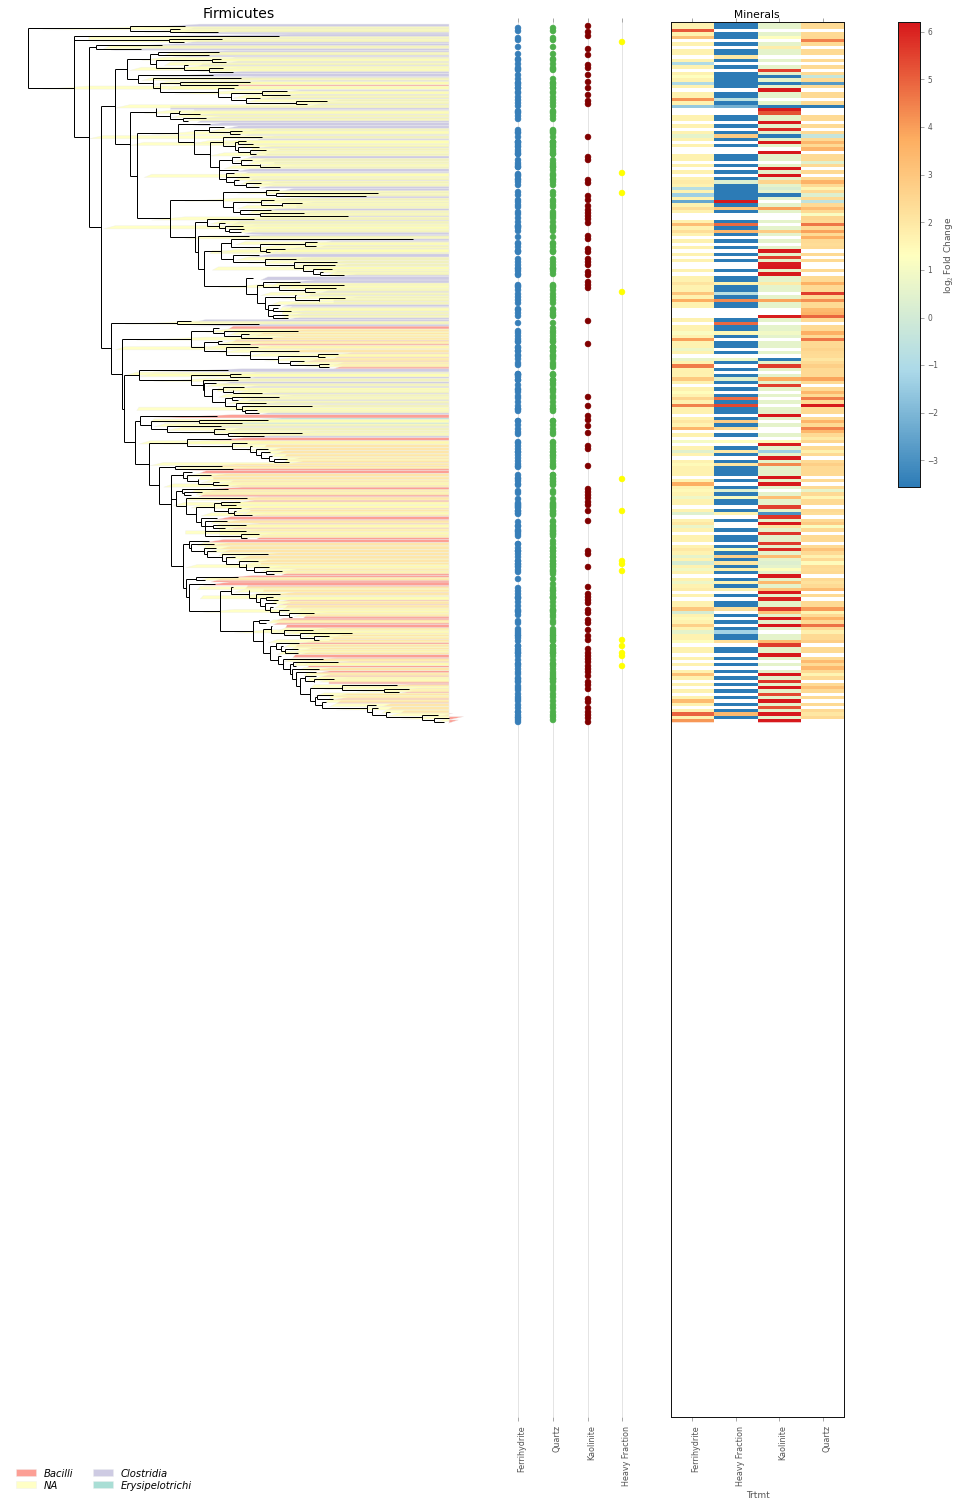

In [317]:
make_tree_fig("Firmicutes", "Phylum", "Class", "../data/l2fcResp.csv", "physeq", 
              save_fn = "Firmicutes_tree.pdf", lw_tax = 1, leg_spacing = 0.03, pt_size = 35)
FileLink("Firmicutes_tree.pdf")

/Users/Thea/Documents/Box Sync (whitman@berkeley.edu)/Berkeley/Research/Minerals/illumina/16S/Mineral16S/manuscript_figures/Gemm_tree.pdf

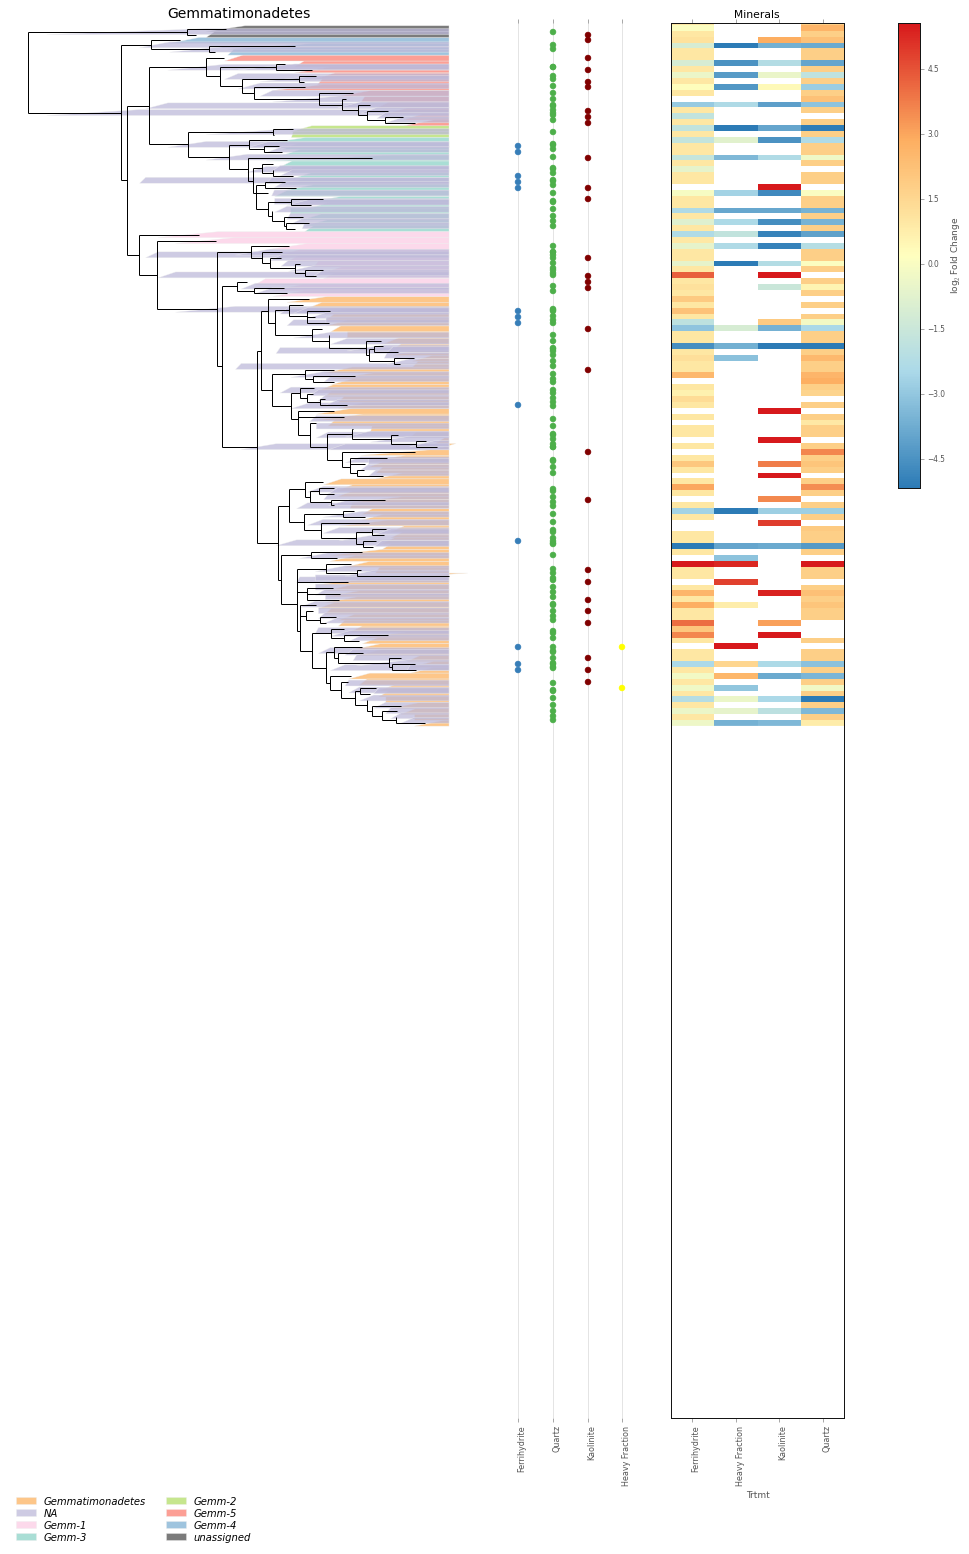

In [305]:
make_tree_fig("Gemmatimonadetes", "Phylum", "Class", "../data/l2fcResp.csv", "physeq", 
              save_fn = "Gemm_tree.pdf", lw_tax = 1, leg_spacing = 0.05,
              pt_size = 35)
FileLink("Gemm_tree.pdf")

/Users/Thea/Documents/Box Sync (whitman@berkeley.edu)/Berkeley/Research/Minerals/illumina/16S/Mineral16S/manuscript_figures/acido_tree.pdf

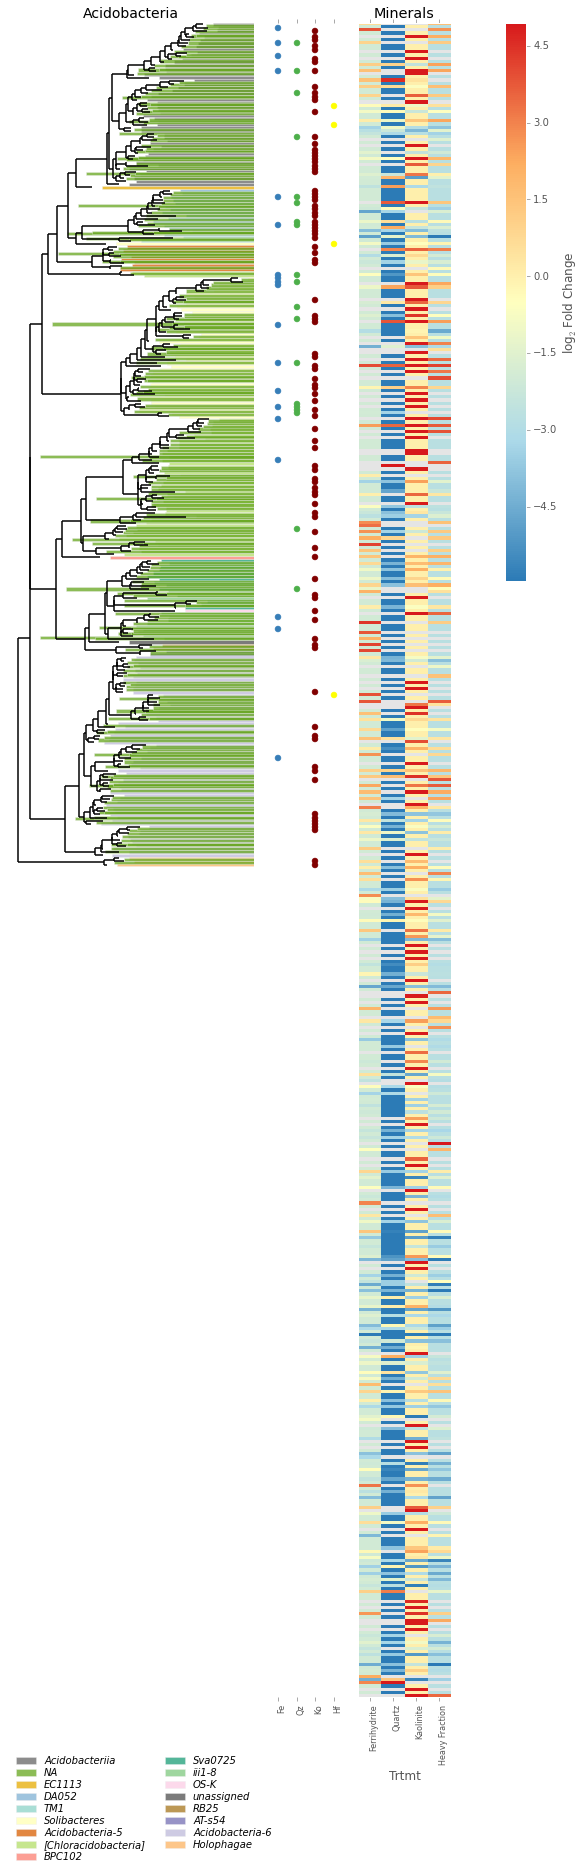

In [267]:
make_tree_fig("Acidobacteria", "Phylum", "Class","../data/l2fcResp.csv", "physeq", 
              save_fn = "acido_tree.pdf", lw_tax = 1, leg_spacing = 0.03,
              pt_size = 35)
FileLink("acido_tree.pdf")

In [ ]:

#    ax3 = fig.add_subplot(gs[2], sharey = ax1)
#    ax3.set_title("Fe")
#    df = l2fc_df.pivot_table(index=["y"], columns=["Month","Trtmt"], values=["l2FC"])
#    df = df_pivot["2"]
#    df =pd.DataFrame(df)
#    df["y"]= df.index
#    df = df[["y","Ferrihydrite"]]
#    im = ax3.imshow(df.as_matrix(), interpolation="nearest", aspect="auto", cmap=cm, vmax=vmax, vmin=vmin)
#    ax3.grid(False)  

#    ax4 = fig.add_subplot(gs[3], sharey = ax1)
#    ax4.set_title("Qz")
#    df = df_pivot["Quartz"]
#    df =pd.DataFrame(df)
#    df["y"]= df.index
#    df = df[["y","Quartz"]]
#    im = ax4.imshow(df.as_matrix(), interpolation="nearest", aspect="auto", cmap=cm, vmax=vmax, vmin=vmin)
#    ax4.grid(False)
    
#    ax5 = fig.add_subplot(gs[4], sharey = ax1)
#    ax5.set_title("Ko")
#    df = df_pivot["Kaolinite"]
#    df =pd.DataFrame(df)
#    df["y"]= df.index
#    df = df[["y","Kaolinite"]]    
#    im = ax5.imshow(df.as_matrix(), interpolation="nearest", aspect="auto", cmap=cm, vmax=vmax, vmin=vmin)
#    ax5.grid(False)
    
#    ax6 = fig.add_subplot(gs[5], sharey = ax1)
#    ax6.set_title("Hf")
#    df = df_pivot["Heavy Fraction"]
#    df =pd.DataFrame(df)
#    df["y"]= df.index
#    df = df[["y","Heavy Fraction"]]      
#    im = ax6.imshow(df.as_matrix(), interpolation="nearest", aspect="auto", cmap=cm, vmax=vmax, vmin=vmin)
#    ax6.grid(False)